## FEM solver for wave equation with point source

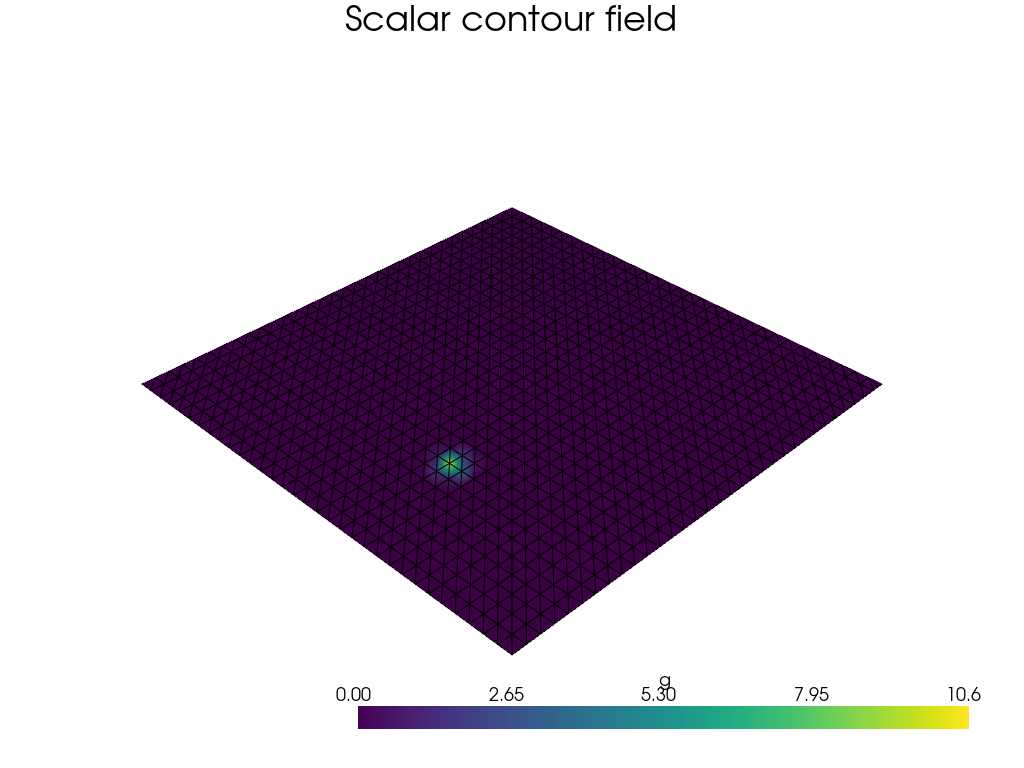

In [8]:
from dolfinx import fem, mesh, plot, io
from dolfinx.fem.petsc import LinearProblem
from petsc4py.PETSc import ScalarType
from mpi4py import MPI
import numpy as np
from ufl import ds, dx, grad, inner
import ufl
import matplotlib as mpl
import pyvista

def solveWaveEquation(V: fem.function.FunctionSpace, g: fem.Function=None,
                    dt: float=0.0001, T:float=1, bcs=[], 
                        waveSpeed=1, x1=None, x2=None, file=None):
    msh = V.mesh
    def initial_condition(x, a=5):
        return np.exp(-a * (x[0]**2 + x[1]**2))*0.0

    u0 = fem.Function(V)
    u0.interpolate(initial_condition)

    u1 = fem.Function(V)
    u1.interpolate(initial_condition)

    signal = lambda t: (1 - 2 * t) if t < 0.5 else ((2 - 2 * t) if t < 1 else 0.0)
    p1 = fem.Constant(msh, 0.0)

    #Define time discret variational problem
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)
    c = (dt**2 * waveSpeed**2)

    a = inner(u,  v) * dx + c * inner(grad(u),grad(v)) * dx
    L = 2*inner(u1,v)*dx - inner(u0,v)*dx + c * inner(g,v) * dx

    t_values = np.linspace(0, T, int(T/dt))
    y_values = np.array([signal(t) for t in t_values])
    
    #plt.plot(t_values, y_values, label='(1 - 2 * t) if t < 0.5 else (2 - 2 * t)')
    #plt.xlabel('t')
    #plt.ylabel('f(t)')
    #plt.title('Piecewise Function Plot')
    #plt.legend()
    #plt.grid(True)
    #plt.show()

    grid1 = pyvista.UnstructuredGrid(*plot.vtk_mesh(V))
    grid1.point_data["g"] = g.x.array
    grid1.set_active_scalars("g")

    plotDirac = pyvista.Plotter()
    plotDirac.add_text("Scalar contour field", font_size=14, color="black", position="upper_edge")
    plotDirac.add_mesh(grid1, show_edges=True, show_scalar_bar=True)
    plotDirac.show()
    
    grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V))
    plotter = pyvista.Plotter()
    plotter.open_gif("u_time.gif", fps=10)

    grid.point_data["uh"] = u0.x.array
    warped = grid.warp_by_scalar("uh", factor=1)

    viridis = mpl.colormaps.get_cmap("viridis").resampled(25)
    sargs = dict(title_font_size=25, label_font_size=20, fmt="%.2e", color="black",
                position_x=0.1, position_y=0.8, width=0.8, height=0.1)

    renderer = plotter.add_mesh(warped, show_edges=True, lighting=False,
                            cmap=viridis, scalar_bar_args=sargs,
                            clim=[0, max(u0.x.array)])
    
    if pyvista.OFF_SCREEN:
        pyvista.start_xvfb(wait=0.1)
        plotter.screenshot("uh_poisson.png")
    #else:
    #    plotter.show()

    interval = np.linspace(0, T, int(T/dt))
    for t in interval:
        p1.value = signal(t)
        problem = LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
        u = problem.solve()
        u0.x.array[:] = u1.x.array
        u1.x.array[:] = u.x.array
        if (file):
            file.write_function(u, t)
        new_warped = grid.warp_by_scalar("uh", factor=1)
        warped.points[:, :] = new_warped.points
        warped.point_data["uh"][:] = u0.x.array
        plotter.write_frame()
    
    plotter.close()
    return u

# Initialize mesh
msh = mesh.create_rectangle(
    comm=MPI.COMM_WORLD,
    points=((-1.0, -1.0), (1.0, 1.0)),
    n=(32, 32),
    cell_type=mesh.CellType.triangle,
)
V = fem.functionspace(msh, ("Lagrange", 1))
alpha = 0.05
x1 = (0.5, 0.2)
g = fem.Function(V)
g.interpolate(lambda x : 1/(np.abs(alpha)*np.sqrt(np.pi))*np.exp(-(((x[0]-x1[0])**2+(x[1]-x1[1])**2)/(alpha**2))))

# Open file and write mesh to it
file = io.XDMFFile(msh.comm, "output/2dwave.xdmf", "w")
file.write_mesh(msh)
u = solveWaveEquation(V, dt=0.1, g=g, T=0.5, file=file, waveSpeed=50)

file.close()

# Run the solver

# Visualize

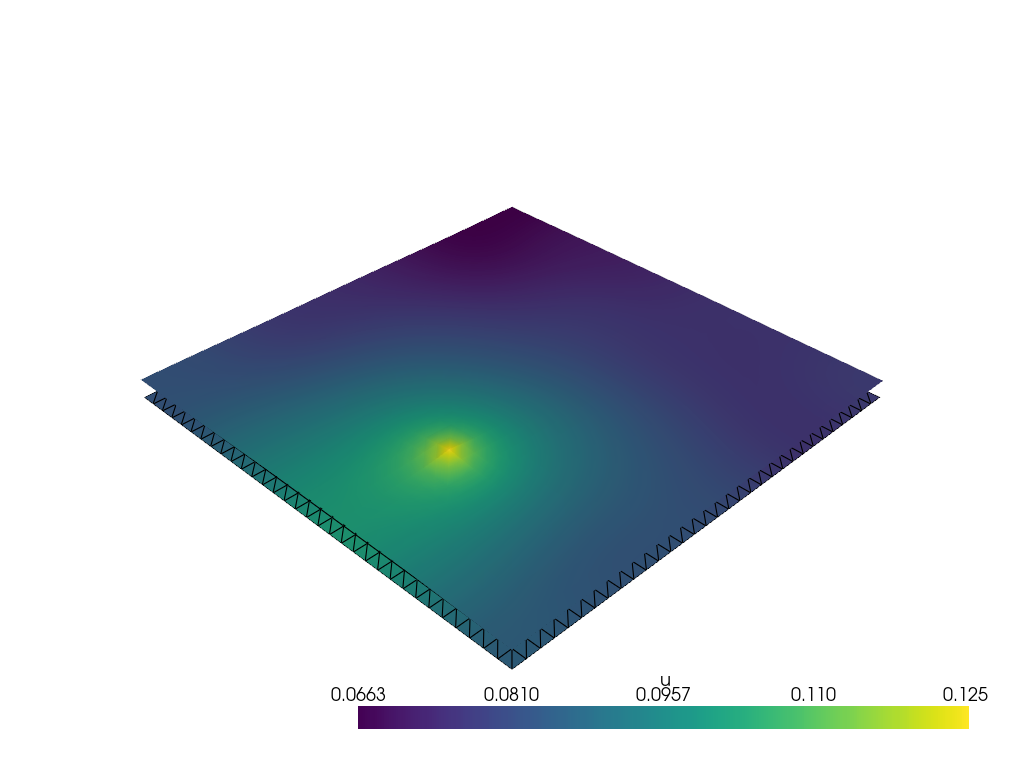

In [2]:
try:
    import pyvista

    V = fem.functionspace(msh, ("Lagrange", 1))
    cells, types, x = plot.vtk_mesh(V)
    grid = pyvista.UnstructuredGrid(cells, types, x)
    grid.point_data["u"] = u.x.array.real
    grid.set_active_scalars("u")
    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, show_edges=True)
    warped = grid.warp_by_scalar()
    plotter.add_mesh(warped)
    if pyvista.OFF_SCREEN:
        pyvista.start_xvfb(wait=0.1)
        plotter.screenshot("uh_poisson.png")
    else:
        plotter.show()
except ModuleNotFoundError:
    print("'pyvista' is required to visualise the solution")
    print("Install 'pyvista' with pip: 'python3 -m pip install pyvista'")

In [3]:
# Create a point source for Poisson problem
# Author: Jørgen S. Dokken
# SPDX-License-Identifier: MIT

from mpi4py import MPI
from petsc4py import PETSc

import dolfinx
import dolfinx.fem.petsc
import numpy as np
import ufl


def compute_cell_contributions(V, points):
    # Determine what process owns a point and what cells it lies within
    mesh = V.mesh
    _, _, owning_points, cells = dolfinx.cpp.geometry.determine_point_ownership(
        mesh._cpp_object, points, 1e-6)
    owning_points = np.asarray(owning_points).reshape(-1, 3)

    # Pull owning points back to reference cell
    mesh_nodes = mesh.geometry.x
    cmap = mesh.geometry.cppmap[0]
    ref_x = np.zeros((len(cells), mesh.geometry.dim),
                     dtype=mesh.geometry.x.dtype)
    for i, (point, cell) in enumerate(zip(owning_points, cells)):
        geom_dofs = mesh.geometry.dofmap[cell]
        ref_x[i] = cmap.pull_back(point.reshape(-1, 3), mesh_nodes[geom_dofs])

    # Create expression evaluating a trial function (i.e. just the basis function)
    u = ufl.TrialFunction(V)
    num_dofs = V.dofmap.dof_layout.num_dofs * V.dofmap.bs
    if len(cells) > 0:
        # NOTE: Expression lives on only this communicator rank
        expr = dolfinx.fem.Expression(u, ref_x, comm=MPI.COMM_SELF)
        values = expr.eval(mesh, np.asarray(cells, dtype=np.int32))

        # Strip out basis function values per cell
        basis_values = values[:num_dofs:num_dofs*len(cells)]
    else:
        basis_values = np.zeros(
            (0, num_dofs), dtype=dolfinx.default_scalar_type)
    return cells, basis_values


N = 80
domain = dolfinx.mesh.create_unit_square(MPI.COMM_WORLD, N, N)
domain.name = "mesh"
domain.topology.create_connectivity(1, 2)

V = dolfinx.fem.functionspace(domain, ("Lagrange", 1))

facets = dolfinx.mesh.exterior_facet_indices(domain.topology)

if domain.comm.rank == 0:
    points = np.array([[0.68, 0.36, 0]], dtype=domain.geometry.x.dtype)
else:
    points = np.zeros((0, 3), dtype=domain.geometry.x.dtype)


u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
a = ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
a_compiled = dolfinx.fem.form(a)


dofs = dolfinx.fem.locate_dofs_topological(V, 1, facets)
u_bc = dolfinx.fem.Constant(domain, 0.)
bc = dolfinx.fem.dirichletbc(u_bc, dofs, V)

b = dolfinx.fem.Function(V)
b.x.array[:] = 0
cells, basis_values = compute_cell_contributions(V, points)
for cell, basis_value in zip(cells, basis_values):
    dofs = V.dofmap.cell_dofs(cell)
    b.x.array[dofs] += basis_value
dolfinx.fem.petsc.apply_lifting(b.vector, [a_compiled], [[bc]])
b.x.scatter_reverse(dolfinx.la.InsertMode.add)
dolfinx.fem.petsc.set_bc(b.vector, [bc])
b.x.scatter_forward()

A = dolfinx.fem.petsc.assemble_matrix(a_compiled, bcs=[bc])
A.assemble()

ksp = PETSc.KSP().create(domain.comm)
ksp.setOperators(A)
ksp.setType(PETSc.KSP.Type.PREONLY)
ksp.getPC().setType(PETSc.PC.Type.LU)
ksp.getPC().setFactorSolverType("mumps")


uh = dolfinx.fem.Function(V)
ksp.solve(b.vector, uh.vector)
uh.x.scatter_forward()

with dolfinx.io.VTXWriter(domain.comm, "uh.bp", [uh], engine="BP4") as bp:
    bp.write(0.0)

AttributeError: 'dolfinx.cpp.mesh.Geometry_float64' object has no attribute 'cppmap'